# Sentiment Analysis for Hotel Reviews

## Overview
This project is analyzing sentiment in hotel reviews using **Mutual Information** and **Vader Sentiment Analyzer**. We crawl hotel review data from Trip Advisor website by using a python script which can be downloaded at [here](https://github.com/aesuli/trip-advisor-crawler).

We use **Vader sentiment analyzer, Mutual Information and Point-wise Mutual Information** to discover the relation between those metrics and ground-truth rating scores.

## What we are going to do

1. Crawl hotel review data from Trip Advisor by using a python script ([click](https://github.com/aesuli/trip-advisor-crawler) to see how to use the script)

2. Read the data (.csv format) into **pandas dataframe**

3. Use **Vader sentiment analyzer****bag-of-words model** (unigram)

4. Calculate **word frequency**, **mutual information** and **pointwise mutual information** for the unigrams to see how they relate with the review scores

5. **Visualize** the distribution of the ground-truth scores and Vader scores
6. Discuss

### Install and import the packages

In [1]:
#Download required ntlk packages and lib
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

### Test the Vader analyzer

In [3]:
#Sentences to try with vader
sentences = ["VADER is smart, handsome, and funny.",
             "Data Scientists are sexy!",
             "The room was dirty and small",
             "They had excellent facilities!",
             "This hotel is the worst hotel in the city"]

In [4]:
#Instantiate an instance to access SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

In [5]:
#Vader output
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



It can be seen from the previous examples that **Vader sentiment analyzer** does good job in identifying polarity of the sentences and give us **compound** score which is in range of [-1, 1]. As compound is close to +1.0, the sentence has positive words and mood.

## Let's read the .csv data we scrapped from Trip Advisor

In [6]:
# Read in from pandas
hotelDf = pd.read_csv('JBnyc10.csv')
hotelDf.columns=['filePath','hotelName','review','ratingScore','groundTruth']

In [8]:
hotelDf.shape

(1648, 5)

In [11]:
# There are unparsed html tags in the hotelnames. We can changed the html tags to ascii equivalents by using the following code.
for i in range(len(hotelDf)):
    hotelname = hotelDf.at[i, 'hotelName']
    hotelname = hotelname.encode("utf-8")
    hotelname = hotelname.decode("ascii", "ignore")
    hotelname = html.unescape(hotelname)
    hotelDf.at[i, 'hotelName'] = hotelname

One thing we can notice here is the groundtruth is categorical variable ('positive', 'negative'). If the rating score is 4 or 5, we say the ground truth is positive, otherwise we say it is negative.

In [9]:
# Instantiate the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [10]:
vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d reviews" % (rownum+1))
print("completed")

processed 1 reviews
processed 1001 reviews
completed


In [57]:
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,vaderScore
0,OUT/com/60763/10131859/441941812.html,EVEN Hotel New York - Midtown East,"""Just stayed with the family at the new Even h...",5,positive,0.9661
1,OUT/com/60763/10131859/442005756.html,EVEN Hotel New York - Midtown East,"""We were one of the very first people to arriv...",5,positive,0.9818
2,OUT/com/60763/10131859/442971892.html,EVEN Hotel New York - Midtown East,"""A nice new hotel in New York City. They are s...",4,positive,0.8910
3,OUT/com/60763/10131859/442987481.html,EVEN Hotel New York - Midtown East,"""I travel quite often between both coasts and ...",5,positive,0.9970
4,OUT/com/60763/10131859/443109624.html,EVEN Hotel New York - Midtown East,"""This was my first time staying at any EVEN ho...",5,positive,0.9859
5,OUT/com/60763/10131859/443362003.html,EVEN Hotel New York - Midtown East,"""We love this place! The room is very well-des...",5,positive,0.9598
6,OUT/com/60763/10131859/443634840.html,EVEN Hotel New York - Midtown East,"""Stayed for 3 nights on a business trip, super...",5,positive,0.9690
7,OUT/com/60763/10131859/445952953.html,EVEN Hotel New York - Midtown East,"""I stayed at the EVEN Hotel because it was sug...",5,positive,0.9713
8,OUT/com/60763/10131859/445986589.html,EVEN Hotel New York - Midtown East,"""I was here for work at Memorial Sloan Ketteri...",5,positive,0.9931
9,OUT/com/60763/10131859/446086203.html,EVEN Hotel New York - Midtown East,"""New hotel, great location, awesome staff and ...",5,positive,0.9450


In [90]:
hotelDf[hotelDf['review'].str.contains("u0438")]['review']

899    "+ It\\'s very modern brand new hotel with hig...
Name: review, dtype: object

In [33]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth,vaderScore
0,OUT/com/60763/10131859/441941812.html,EVEN Hotel New York - Midtown East,"""Just stayed with the family at the new Even h...",5,positive,0.9661
1,OUT/com/60763/10131859/442005756.html,EVEN Hotel New York - Midtown East,"""We were one of the very first people to arriv...",5,positive,0.9818
2,OUT/com/60763/10131859/442971892.html,EVEN Hotel New York - Midtown East,"""A nice new hotel in New York City. They are s...",4,positive,0.8910
3,OUT/com/60763/10131859/442987481.html,EVEN Hotel New York - Midtown East,"""I travel quite often between both coasts and ...",5,positive,0.9970
4,OUT/com/60763/10131859/443109624.html,EVEN Hotel New York - Midtown East,"""This was my first time staying at any EVEN ho...",5,positive,0.9859


## Can we learn something about the true ratings from Vader scores?
In other words, can we build infer true review ratings by using vader score? and why even would we be intereted in that?

Usually, we have many other options for the regression problem. *Linear Regression*, *Decision Tree* and etc.

But using Vader analyzer is **simple and fast**. We can use it as an initial tool before building a heavy machine learning model to figure out the trend in the data.

#### Top 5 reviews hotel by *ratings*

In [13]:
ratingByHotel = hotelDf.groupby(['hotelName']).mean()['ratingScore'].reset_index()
vaderByHotel = hotelDf.groupby(['hotelName']).mean()['vaderScore'].reset_index()

In [14]:
ratingByHotel = ratingByHotel.sort_values('ratingScore', ascending=False)
ratingByHotel.head(10)

,hotelName,ratingScore
2,Chez Michelle,4.900000
5,Greenwich Hotel,4.689139
1,Carnegie Hotel,4.604651
0,Arlo NoMad,4.581281
3,EVEN Hotel New York - Midtown East,4.493113
6,Hyatt House New York/Chelsea,4.404844
4,Fairfield Inn &amp; Suites New York Manhattan/...,4.302013
7,The Hotel 91,3.626335


#### Top 5 reviews hotel by *vader score*

In [15]:
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel.head(10)

,hotelName,vaderScore
1,Carnegie Hotel,0.919258
0,Arlo NoMad,0.910730
2,Chez Michelle,0.908860
5,Greenwich Hotel,0.906730
3,EVEN Hotel New York - Midtown East,0.870220
4,Fairfield Inn &amp; Suites New York Manhattan/...,0.808779
6,Hyatt House New York/Chelsea,0.774641
7,The Hotel 91,0.685318


### The two lists are very similar!
Vader scores are highly correlated with the true rating scores.

## Which words were most sentiment-bearing in the reviews?
#### To explore this question, we will calculate the following 3 factors.
1. Word Frequency
2. Mutual Information
3. Pointwise Mutual Information (PMI)

### 1. Word Frequency
Can word frequency in review data tell us how the customers felt about the hotels?


Let's get the most frequently observed words from the *positive reviews* and *negative reviews*, respectively, to see the difference, if any.

In [16]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for name in hotelDf.hotelName.unique():
            for token in name.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

#### Top 10 Words with High Frequency in *Positive* and *Negative* reviews.

In [17]:
topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amp', 'arlo', 'carnegie', 'central', 'chelsea', 'chez', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'hyatt', 'inn', 'manhattan', 'michelle', 'midtown', 'new', 'nomad', 'park', 'suites', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amp', 'arlo', 'carnegie', 'central', 'chelsea', 'chez', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'hyatt', 'inn', 'manhattan', 'michelle', 'midtown', 'new', 'nomad', 'park', 'suites', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/fe

The most frequently occured top 10 words in positive reviews
        Word  Count
0      hotel   2329
1       room   1757
2      great   1059
3      staff    952
4       stay    865
5      rooms    684
6      clean    634
7   location    582
8       good    556
9  breakfast    555

The most frequently occured top 10 words in negative reviews
    Word  Count
0  hotel    559
1   room    535
2  staff    180
3   stay    175
4  rooms    163
5   good    137
6   just    124
7  night    122
8   time    112
9   nice    108

The most frequently occured top 10 bigrams in positive reviews
               Word  Count
0          new york    279
1    staff friendly    126
2      empire state    115
3      central park    115
4      times square    114
5    state building    103
6  walking distance    100
7  friendly helpful     98
8    great location     95
9       rooms small     93

The most frequently occured top 10 bigrams in negative reviews
               Word  Count
0          new york     41
1 

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amp', 'arlo', 'carnegie', 'central', 'chelsea', 'chez', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'hyatt', 'inn', 'manhattan', 'michelle', 'midtown', 'new', 'nomad', 'park', 'suites', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Uh.. almost same?
It seems like the term frequency doesn't tell us anything about the text. We can observe that there is no difference between the top-k word list for both positive reviews and negative reviews.

If we think about it, this result seems obvious. If a customer was really satistied with breakfast, they would mention the word, 'breakfast', in their review. Even if a customer didn't like their breakfast, they also would mention the word, 'breakfast', in their review (with some bad words).

### 2. Mutual Information

**Mutual information tells you how much you learn about X from knowing the value of Y (on average over the choice of Y).** 


Since we found the word frequency is not a good indicator for the sentiment analysis, we will examine *mutual information*  for an alternative metric.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

In [18]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [19]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())

In [20]:
miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

Mutual Information - Unigram


,MI Score
great,0.024103
bad,0.015839
told,0.015706
loved,0.015098
room,0.014015
asked,0.013784
chinatown,0.012002
night,0.011617
amazing,0.010844
elevator,0.010810


In [21]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
highly recommend,0.006651
definitely stay,0.005801
arlo nomad,0.005318
hotel 91,0.004549
room did,0.004409
china town,0.004315
great stay,0.003861
didn work,0.003765
times square,0.003726
credit card,0.003673


### What does it mean?
If we observe words having high Mutual Information scores in a review, we would learn a lot about the sentiment of review, (positive or negative).

###  3. Pointwise Mutual Information

Similar to MI, PMI is measuring for sigle event where MI is the average of all possible event.

The events P(x,y) = P(0,1) means the event of the review is negative but the specific word is existing in that review

#### Let's see how Pointwise Mutual Information calculated. The PMI of a pair of outcomes x and y belonging to discrete random variables X and Y quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence.
#### To study more about Pointwise Mutual Information, see [Wikipedia](https://en.wikipedia.org/wiki/Pointwise_mutual_information) 

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/ff54cfce726857db855d4dd0a9dee2c6a5e7be99)

In [22]:
def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

From the table above, we can see the word, 'dirty', has negatively correlated with 'positive' label because the pmi value for 'positive' label is the smallest value (-0.69) among the four values.

In [ ]:
hotelDf[hotelDf['']]

In [23]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


### Let's see what PMI values tell us about the reviews

In [24]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
u0430,inf
u043e,inf
u0438,inf
u0435,inf
u043d,inf
nomad,0.078023
birthday,0.078023
thank,0.071184
loved,0.069803
wonderful,0.069751


In [25]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
u043d u0430,inf
u043e u0432,inf
located close,0.078023
stay greenwich,0.078023
easily accessible,0.078023
happy hour,0.078023
shampoo conditioner,0.078023
great place,0.078023
amazing view,0.078023
stay hyatt,0.078023


In [26]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
u0438,inf
u043d,inf
u043e,inf
u0430,inf
u0435,inf
u201d,0.482958
told,0.474358
china,0.467718
bad,0.464208
issues,0.431805


In [27]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
u043d u0430,inf
u043e u0432,inf
didn work,0.587693
credit card,0.562139
big deal,0.549905
room did,0.549905
room quite,0.482958
china town,0.465229
hotel experience,0.448196
say hotel,0.441565


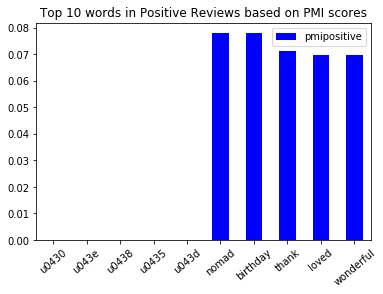

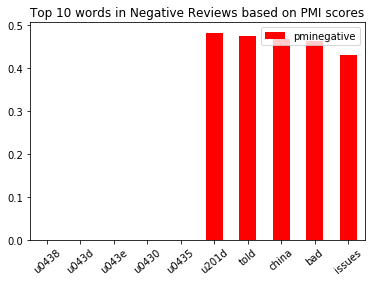

In [28]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

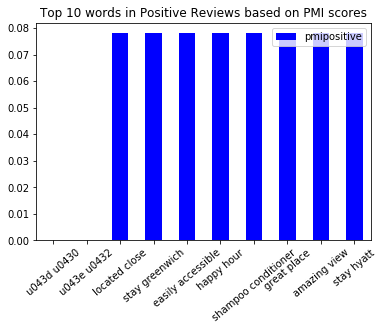

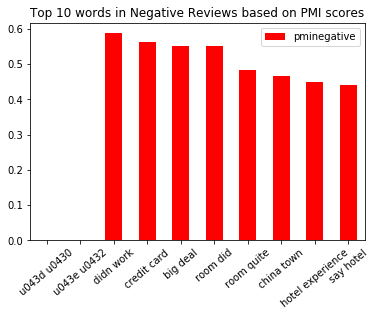

In [29]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

### Pointwise Mutual Information seems like a good metric to summarize the reviews in n-gram tokens!
### By reading the n-gram tokens with high PMI scores for target variable, we can get a sense how much the reviewer did or didn't like the hotels. 

# Visualization
Sometimes, we can learn a lot about the data by visualizing.

## Historgrams

In [ ]:
plt.xlabel('Rating Score')
hotelDf['ratingScore'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

In [ ]:
plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

In [ ]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['ratingScore'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Boxplots

In [ ]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('ratingScore', ascending=False).head(5).hotelName.as_matrix()

tempdf = hotelDf[(hotelDf.hotelName == tp5gthotel[0]) | (hotelDf.hotelName == tp5gthotel[1]) | 
         (hotelDf.hotelName == tp5gthotel[2]) | (hotelDf.hotelName == tp5gthotel[3]) | 
         (hotelDf.hotelName == tp5gthotel[4])]

In [ ]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

In [ ]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

## Scatterplots

In [ ]:
y = hotelDf['ratingScore'].as_matrix()
x = hotelDf['vaderScore'].as_matrix()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()